In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
# notebook plotting for 3d manipulation
#%matplotlib notebook
%matplotlib notebook

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [ ]:
# NOTES

# TODO
# write routine to convert between cartesian and keplerian
# add true anomaly to keplerian state

# DONE
# try tricky (including 3d) initial conditions
## define tricky?
# add ecc vector
# what in odeint will make the conserved quantities variation smaller. (what knob?)
## switched to solve_ivp, RK45, smaller max_step

# 2d plotting code, stored to lazy grab a copy
#plt.figure(figsize=(4, 4))
#plt.axis('equal')
#plt.plot(orbit_state[0,:], orbit_state[1,:],'g')
#plt.show()

In [6]:
# setup and constants
start = time.time()

MU           = 398600.4414
EARTH_RADIUS = 6356 # km

PLOT_FIGSIZE = (12,4)
EARTH_FIGSIZE = (6,6)

def setup3dEarth(figsize, orbit_solution):
    # build a 3d plot with an earth-sized sphere, suitable
    # for plotting orbits on
    ax = p3.Axes3D(plt.figure(figsize=figsize))


    PANE_BG = (0.3, 0.3, 0.3, 1.0)
    ax.w_xaxis.set_pane_color(PANE_BG)
    ax.w_yaxis.set_pane_color(PANE_BG)
    ax.w_zaxis.set_pane_color(PANE_BG)
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True
    ax.grid(False)
    
    plot_max = max(map(max, orbit_solution)) * 1.1
    ax.set_xlim3d([-plot_max, plot_max])
    ax.set_ylim3d([-plot_max, plot_max])
    ax.set_zlim3d([-plot_max, plot_max])
    
    # build 3d earth coordinates
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    earth_x = np.cos(u)*np.sin(v) * EARTH_RADIUS
    earth_y = np.sin(u)*np.sin(v) * EARTH_RADIUS
    earth_z = np.cos(v)           * EARTH_RADIUS
    
    ax.plot_wireframe(earth_x, earth_y, earth_z, color="w", edgecolor=(0.8,0.8,0.8))
    
    return ax

In [5]:
def kepler(t, state):
    (pos, vel) = np.split(state, 2)
    return np.array([ vel, -(MU / np.sum(pos**2)**1.5) * pos ]).flatten()

def kepler_old(state, t):
    (pos, vel) = np.split(state, 2)
    return np.array([ vel, -(MU / np.sum(pos**2)**1.5) * pos ]).flatten()

def calc_energy(state_vector):
    (pos, vel) = np.split(state_vector, 2)
    return np.sum(vel**2) / 2.0 - MU/np.sum(pos**2)**0.5

def calc_h(state_vector):
    (pos, vel) = np.split(state_vector, 2)
    return np.cross(pos, vel)

def calc_e(state_vector, precalc_h=None):
    (pos, vel) = np.split(state_vector, 2)
    
    if precalc_h is not None:
        h = precalc_h
    else:
        h = calc_h(state_vector)
        
    return np.cross(vel, h)/MU - pos / np.sum(pos**2)**0.5

In [ ]:
#import time
#duration = 500000
## I = 80, SMA = 7000
#initial_r = [ -3664.5, 4609.1, -3784.4 ]
#initial_v = [   1.265, -4.095, -6.208  ]
#%matplotlib inline
#rtol = 1e-4
#atol = 1e-6
#iterations = 10
#energy_drift = np.zeros((iterations, 2))
#energy_improvement = np.zeros((iterations-1, 2))
#runtime = np.zeros((iterations, 2))
#
#for i in range(iterations):
#    start = time.time()
#    orbit = solve_ivp(kepler, (0, duration), initial_state, rtol=rtol, atol=atol)
#    runtime[i] = [-np.log10(rtol), time.time() - start]
#    drift = calc_energy(orbit.y[:,0]) - calc_energy(orbit.y[:,-1])
#    energy_drift[i] = [-np.log10(rtol), np.abs(drift)]
#    rtol /= 10
#
#for i in range(len(energy_improvement)):
#    energy_improvement[i] = [ energy_drift[i,0], energy_drift[i,1] / energy_drift[i+1,1] ]
#    
#print(energy_improvement)
#
#plt.figure(figsize=(14,5))
#plt.title('rtol improvement (log) (atol=6 (default))')
#plt.yscale('log')
#plt.plot(energy_improvement[:,0], energy_improvement[:,1], 'r', marker='o')
#plt.show()
#
#plt.figure(figsize=(14,5))
#plt.title('runtime')
#plt.plot(runtime[:,0], runtime[:,1], 'b', marker='o')
#plt.show()
#
#print(0/0)

type(initial_state) <class 'numpy.ndarray'>
3742


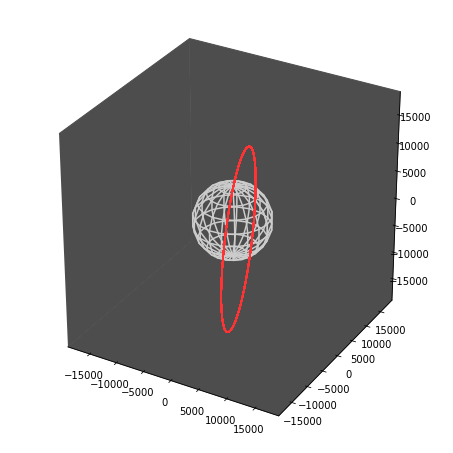

In [7]:
# default initial conditions
initial_r = [ 7000.0, 0.0, 0.0 ]
initial_v = [    0.0, 7.0, 0.0 ]

# I = 80, SMA = 7000
initial_r = [ -3664.5, 4609.1, -3784.4 ]
initial_v = [   1.265, -4.095, -6.208  ]

# I = 80, SMA = 7000, 2km/s in-track burn
initial_r = [ -3847.7, 5577.3, -1757.58 ]
initial_v = [  -0.071, -2.914, -9.090   ]

initial_state   = np.array(initial_r + initial_v)
print('type(initial_state)', type(initial_state))
initial_energy  = calc_energy(initial_state)
initial_h_mag   = np.sum(calc_h(initial_state)**2)**0.5
initial_ecc_vec = calc_e(initial_state)

duration = 500000

orbit_state = solve_ivp(kepler, (0, duration), initial_state, rtol=1e-11)
orbit_solution = orbit_state.y
print(len(orbit_solution[0,:]))

#3d plot
ax = setup3dEarth(figsize=EARTH_FIGSIZE, orbit_solution=orbit_solution)
ax.plot(orbit_solution[0,:], orbit_solution[1,:], orbit_solution[2,:], zorder=9, color=(1.0,0.2,0.2))

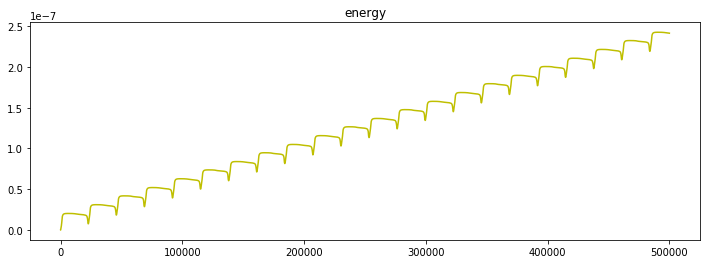

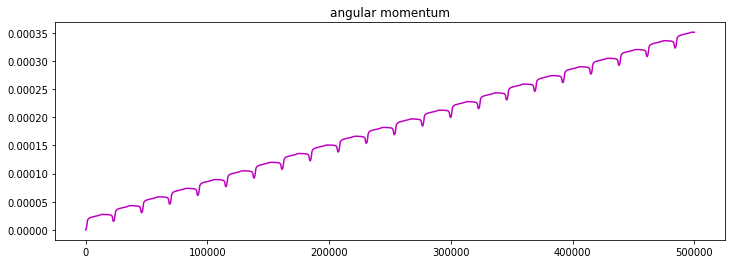

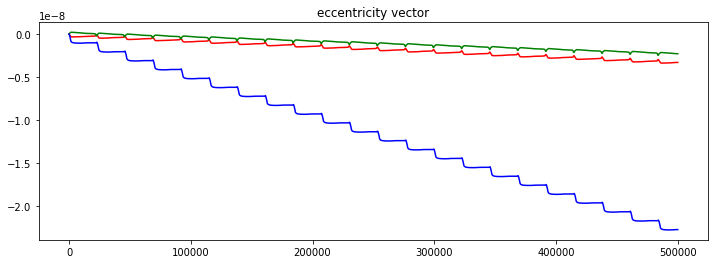

runtime: 36.69895792007446 s


In [8]:
%matplotlib inline

t = orbit_state.t

energy           = []
angular_momentum = []
ecc              = np.zeros((len(t), 3))

# calculate conserved quantities
for i in range(len(t)):
    energy.append( calc_energy(orbit_state.y[:,i]) - initial_energy )
    
    h = calc_h(orbit_state.y[:,i])
    angular_momentum.append( np.sum(h**2)**0.5 - initial_h_mag )

    ecc[i] = calc_e(orbit_state.y[:,i], h) - initial_ecc_vec

plt.figure(figsize=PLOT_FIGSIZE)
plt.title('energy')
plt.plot(t, energy, 'y')
plt.show()

plt.figure(figsize=PLOT_FIGSIZE)
plt.title('angular momentum')
plt.plot(t, angular_momentum, 'm')
plt.show()

plt.figure(figsize=PLOT_FIGSIZE)
plt.title('eccentricity vector')
plt.plot(t, ecc[:,0], 'r')
plt.plot(t, ecc[:,1], 'g')
plt.plot(t, ecc[:,2], 'b')
plt.show()

print('runtime:', (time.time() - start), 's')